In [ ]:
import kagglehub
paramaggarwal_fashion_product_images_dataset_path = kagglehub.dataset_download('paramaggarwal/fashion-product-images-dataset')

print('Data source import complete.')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import pandas as pd
import numpy as np
import json
import os
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class Config:
    BATCH_SIZE = 32
    LATENT_DIM = 512
    IMAGE_SIZE = 128
    EPOCHS = 50
    LEARNING_RATE = 0.0002
    NUM_WORKERS = 2
    TRAIN_SPLIT = 0.8
    AUTOENCODER_EPOCHS = 5

config = Config()

transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [ ]:
class FashionDataset(Dataset):
    def __init__(self, styles_df, images_dir, transform=None):
        self.styles_df = styles_df
        self.images_dir = images_dir
        self.transform = transform
        self.preprocess_data()

    def preprocess_data(self):
        fill_values = {
            'gender': 'Unknown', 'masterCategory': 'Unknown', 'subCategory': 'Unknown',
            'articleType': 'Unknown', 'baseColour': 'Unknown', 'season': 'Unknown',
            'usage': 'Unknown', 'productDisplayName': 'Unknown'
        }

        for col, value in fill_values.items():
            if col in self.styles_df.columns:
                self.styles_df[col] = self.styles_df[col].fillna(value)

        self.categorical_cols = ['gender', 'masterCategory', 'subCategory',
                               'articleType', 'baseColour', 'season', 'usage']
        self.available_categorical_cols = [col for col in self.categorical_cols
                                         if col in self.styles_df.columns]

        self.encoders = {}
        for col in self.available_categorical_cols:
            le = LabelEncoder()
            self.styles_df[col] = le.fit_transform(self.styles_df[col].astype(str))
            self.encoders[col] = le

        self.numerical_cols = []
        if 'year' in self.styles_df.columns:
            self.numerical_cols = ['year']
            self.styles_df['year'] = pd.to_numeric(self.styles_df['year'], errors='coerce')
            year_median = self.styles_df['year'].median()
            self.styles_df['year'] = self.styles_df['year'].fillna(year_median)

    def __len__(self):
        return len(self.styles_df)

    def __getitem__(self, idx):
        row = self.styles_df.iloc[idx]
        product_id = row['id']

        img_path = os.path.join(self.images_dir, f"{product_id}.jpg")
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (config.IMAGE_SIZE, config.IMAGE_SIZE), color='white')

        if self.transform:
            image = self.transform(image)

        metadata_features = self.get_metadata_features(row)

        return image, torch.FloatTensor(metadata_features), product_id

    def get_metadata_features(self, row):
        features = []
        for col in self.available_categorical_cols:
            features.append(float(row[col]))
        for col in self.numerical_cols:
            features.append(float(row[col]))
        return np.array(features)

In [ ]:
class DeepAutoencoderFeatureExtractor(nn.Module):
    def __init__(self, image_latent_dim, metadata_dim, combined_dim):
        super(DeepAutoencoderFeatureExtractor, self).__init__()

        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, image_latent_dim),
            nn.ReLU(),
            nn.BatchNorm1d(image_latent_dim)
        )

        self.image_decoder = nn.Sequential(
            nn.Linear(image_latent_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Unflatten(1, (512, 1, 1)),
            
            nn.ConvTranspose2d(512, 512, 4, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

        self.metadata_encoder = nn.Sequential(
            nn.Linear(metadata_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.metadata_decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, metadata_dim)
        )

        self.combined_processor = nn.Sequential(
            nn.Linear(image_latent_dim + 32, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, combined_dim),
            nn.ReLU(),
            nn.BatchNorm1d(combined_dim)
        )

        self.attention = nn.Sequential(
            nn.Linear(image_latent_dim, image_latent_dim),
            nn.Sigmoid()
        )


    def encode_image(self, x):
        features = self.image_encoder(x)
        attention_weights = self.attention(features)
        return features * attention_weights

    def decode_image(self, z):
        return self.image_decoder(z)

    def encode_metadata(self, x):
        return self.metadata_encoder(x)

    def decode_metadata(self, z):
        return self.metadata_decoder(z)

    def forward(self, images, metadata):
        image_features = self.encode_image(images)
        metadata_features = self.encode_metadata(metadata)

        combined_features = torch.cat([image_features, metadata_features], dim=1)
        final_features = self.combined_processor(combined_features)

        final_features = torch.nn.functional.normalize(final_features, p=2, dim=1)

        return final_features

    def reconstruct_image(self, images):
        encoded = self.encode_image(images)
        return self.decode_image(encoded)

    def reconstruct_metadata(self, metadata):
        encoded = self.encode_metadata(metadata)
        return self.decode_metadata(encoded)

In [ ]:
def train_autoencoders(self, train_loader, metadata_dim):
    autoencoder = DeepAutoencoderFeatureExtractor(
        self.config.LATENT_DIM, metadata_dim, 512
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(),
                          lr=self.config.LEARNING_RATE)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.5,
                                                   patience=3,
                                                   verbose=True)

    print("Training deep autoencoders...")
    autoencoder.train()

    best_loss = float('inf')
    for epoch in range(self.config.AUTOENCODER_EPOCHS):
        total_loss = 0

        for images, metadata, _ in train_loader:
            images = images.to(device)
            metadata = metadata.to(device)

            optimizer.zero_grad()

            reconstructed_images = autoencoder.reconstruct_image(images)
            loss = criterion(reconstructed_images, images)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)

        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{self.config.AUTOENCODER_EPOCHS}] - '
                  f'Loss: {avg_loss:.4f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')

    autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))
    return autoencoder

In [ ]:
def extract_features(self, dataloader, metadata_dim):
    all_features = []
    all_product_ids = []

    print("Training deep autoencoders...")
    train_loader = DataLoader(dataloader.dataset, batch_size=self.config.BATCH_SIZE, shuffle=True)
    self.feature_extractor = self.train_autoencoders(train_loader, metadata_dim)

    print("Extracting features...")
    self.feature_extractor.eval()

    with torch.no_grad():
        for batch_idx, (images, metadata, product_ids) in enumerate(dataloader):
            images = images.to(device)
            metadata = metadata.to(device)

            features = self.feature_extractor(images, metadata)

            all_features.append(features.cpu().numpy())
            all_product_ids.extend(product_ids.numpy())

            if (batch_idx + 1) % 20 == 0:
                print(f"Processed {batch_idx + 1} batches")

    all_features = np.vstack(all_features)
    self.product_features = self.scaler.fit_transform(all_features)
    self.product_ids = np.array(all_product_ids)

    print(f"Final features shape: {self.product_features.shape}")
    return self.product_features, self.product_ids

In [ ]:
class FashionRecommender:
    def __init__(self, config):
        self.config = config
        self.feature_extractor = None
        self.scaler = MinMaxScaler()
        self.knn_model = None
        self.product_features = None
        self.product_ids = None

    def train_autoencoders(self, train_loader, metadata_dim):
        autoencoder = DeepAutoencoderFeatureExtractor(
            self.config.LATENT_DIM, metadata_dim, 512
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(autoencoder.parameters(), lr=self.config.LEARNING_RATE)

        print("Training autoencoders...")
        autoencoder.train()

        for epoch in range(self.config.AUTOENCODER_EPOCHS):
            total_loss = 0
            for images, metadata, _ in train_loader:
                images = images.to(device)
                metadata = metadata.to(device)

                optimizer.zero_grad()

                reconstructed_images = autoencoder.reconstruct_image(images)
                loss = criterion(reconstructed_images, images)

                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            if (epoch + 1) % 5 == 0:
                print(f'Autoencoder Epoch [{epoch+1}/{self.config.AUTOENCODER_EPOCHS}], Loss: {total_loss/len(train_loader):.4f}')

        return autoencoder

    def extract_features(self, dataloader, metadata_dim):
        all_features = []
        all_product_ids = []

        print("Training image autoencoder...")
        train_loader = DataLoader(dataloader.dataset, batch_size=self.config.BATCH_SIZE, shuffle=True)
        self.feature_extractor = self.train_autoencoders(train_loader, metadata_dim)

        print("Extracting features...")
        self.feature_extractor.eval()

        with torch.no_grad():
            for batch_idx, (images, metadata, product_ids) in enumerate(dataloader):
                images = images.to(device)
                metadata = metadata.to(device)

                image_features = self.feature_extractor.encode_image(images)
                features = torch.nn.functional.normalize(image_features, p=2, dim=1)

                all_features.append(features.cpu().numpy())
                all_product_ids.extend(product_ids.numpy())

                if (batch_idx + 1) % 50 == 0:
                    print(f"Processed {batch_idx + 1} batches")

        all_features = np.vstack(all_features)
        self.product_features = self.scaler.fit_transform(all_features)
        self.product_ids = np.array(all_product_ids)

        print(f"Final features shape: {self.product_features.shape}")
        return self.product_features, self.product_ids

    def build_recommendation_index(self):
        self.knn_model = NearestNeighbors(
            n_neighbors=11,
            metric='cosine',
            algorithm='auto'
        )
        self.knn_model.fit(self.product_features)
        print("Recommendation index built!")

    def get_recommendations(self, product_id, n_recommendations=5):
        if product_id not in self.product_ids:
            return []

        idx = np.where(self.product_ids == product_id)[0][0]
        product_feature = self.product_features[idx].reshape(1, -1)

        distances, indices = self.knn_model.kneighbors(product_feature, n_neighbors=n_recommendations + 2)

        recommendations = []
        seen_ids = set()

        for i in range(1, len(indices[0])):
            rec_id = self.product_ids[indices[0][i]]
            if rec_id != product_id and rec_id not in seen_ids:
                distance = distances[0][i]
                similarity = 1.0 - distance  
                recommendations.append((rec_id, similarity))
                seen_ids.add(rec_id)

            if len(recommendations) >= n_recommendations:
                break

        return recommendations

In [ ]:
def main():
    print("Loading data...")
    styles_df = pd.read_csv('../input/fashion-product-images-dataset/fashion-dataset/styles.csv', on_bad_lines='skip', engine='python')
    images_dir = '../input/fashion-product-images-dataset/fashion-dataset/images'

    print(f"Dataset size: {len(styles_df)}")

    styles_df = styles_df.head(1000)  

    dataset = FashionDataset(styles_df, images_dir, transform)
    metadata_dim = len(dataset.available_categorical_cols) + len(dataset.numerical_cols)
    print(f"Metadata dimension: {metadata_dim}")

    recommender = FashionRecommender(config)

    print("Extracting features with autoencoders...")
    features, product_ids = recommender.extract_features(
        DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=False),
        metadata_dim
    )

    print("Building recommendation index...")
    recommender.build_recommendation_index()

    torch.save(recommender.feature_extractor.state_dict(), 'autoencoder_feature_extractor.pth')
    np.save('product_features.npy', features)
    np.save('product_ids.npy', product_ids)

    print("Recommender system ready!")

    test_ids = product_ids[:3] if len(product_ids) >= 3 else product_ids
    for test_id in test_ids:
        print(f"\n{'='*50}")
        print(f"Testing product ID: {test_id}")

        recommendations = recommender.get_recommendations(test_id, 3)

        if recommendations:
            print(f"Top recommendations for product {test_id}:")
            for i, (rec_id, similarity) in enumerate(recommendations, 1):
                print(f"{i}. Product ID: {rec_id}, Similarity: {similarity:.3f}")

            visualize_recommendations(test_id, recommender, styles_df, images_dir, 7)
        else:
            print(f"No recommendations found for product {test_id}")

    return recommender

In [ ]:
def visualize_recommendations(product_id, recommender, styles_df, images_dir, n_recommendations=5):
    recommendations = recommender.get_recommendations(product_id, n_recommendations)

    if not recommendations:
        print(f"No recommendations found for product {product_id}")
        return

    fig, axes = plt.subplots(1, min(n_recommendations + 1, 6), figsize=(18, 4))

    query_img_path = os.path.join(images_dir, f"{product_id}.jpg")
    try:
        query_img = Image.open(query_img_path)
        axes[0].imshow(query_img)
        axes[0].set_title(f"Query\nID: {product_id}", fontsize=10, fontweight='bold')
    except:
        axes[0].imshow(np.zeros((100, 100, 3), dtype=np.uint8))
        axes[0].set_title(f"Query\nID: {product_id}\n(Not found)", fontsize=10)
    axes[0].axis('off')

    for i, (rec_id, similarity) in enumerate(recommendations, 1):
        if i >= len(axes):
            break

        rec_img_path = os.path.join(images_dir, f"{rec_id}.jpg")
        try:
            rec_img = Image.open(rec_img_path)
            axes[i].imshow(rec_img)
            axes[i].set_title(f"Rec {i}\nID: {rec_id}\nSim: {similarity:.3f}", fontsize=10)
        except:
            axes[i].imshow(np.zeros((100, 100, 3), dtype=np.uint8))
            axes[i].set_title(f"Rec {i}\nID: {rec_id}\nSim: {similarity:.3f}", fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Fashion Recommendations for Product {product_id}", fontsize=14, fontweight='bold')
    plt.show()

Loading data...
Dataset size: 44424
Metadata dimension: 8
Extracting features with autoencoders...
Training image autoencoder...
Training autoencoders...
Autoencoder Epoch [5/5], Loss: 0.0354
Extracting features...
Final features shape: (1000, 512)
Building recommendation index...
Recommendation index built!
Recommender system ready!

Testing product ID: 15970
Top recommendations for product 15970:
1. Product ID: 13421, Similarity: 0.989
2. Product ID: 12197, Similarity: 0.985
3. Product ID: 15189, Similarity: 0.981


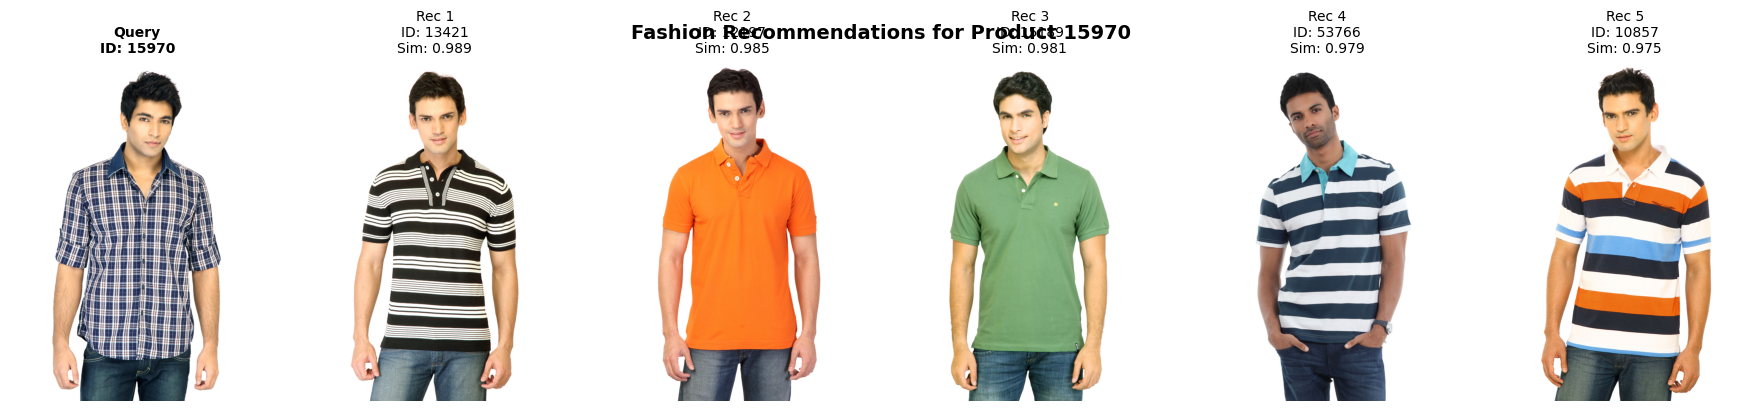


Testing product ID: 39386
Top recommendations for product 39386:
1. Product ID: 26163, Similarity: 0.966
2. Product ID: 16508, Similarity: 0.963
3. Product ID: 27622, Similarity: 0.957


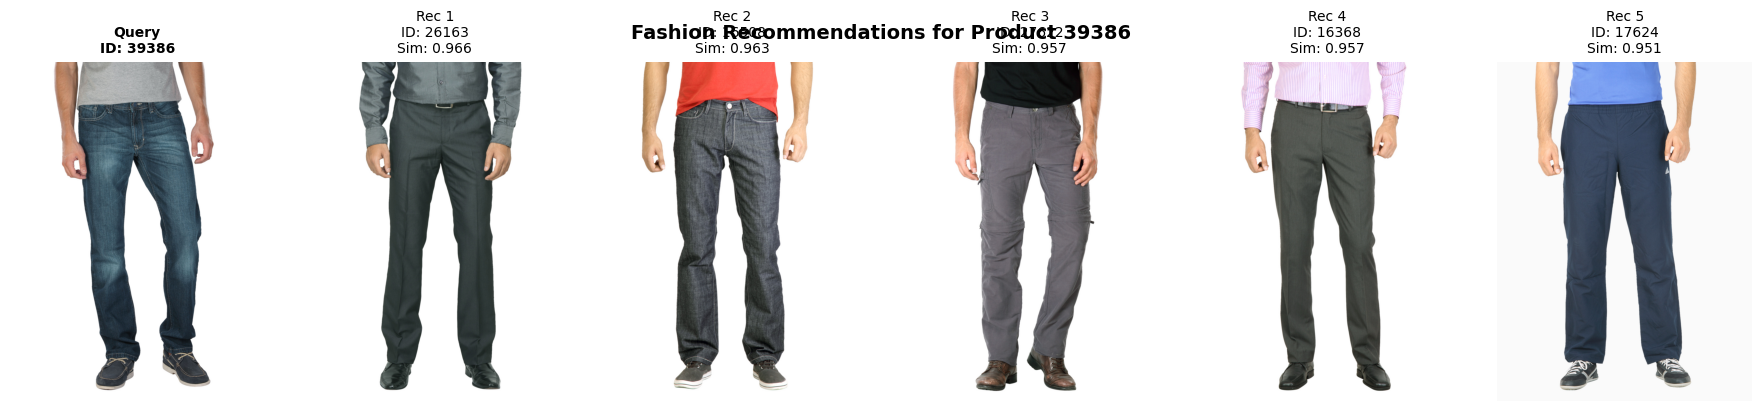


Testing product ID: 59263
Top recommendations for product 59263:
1. Product ID: 37481, Similarity: 0.997
2. Product ID: 53591, Similarity: 0.996
3. Product ID: 25520, Similarity: 0.993


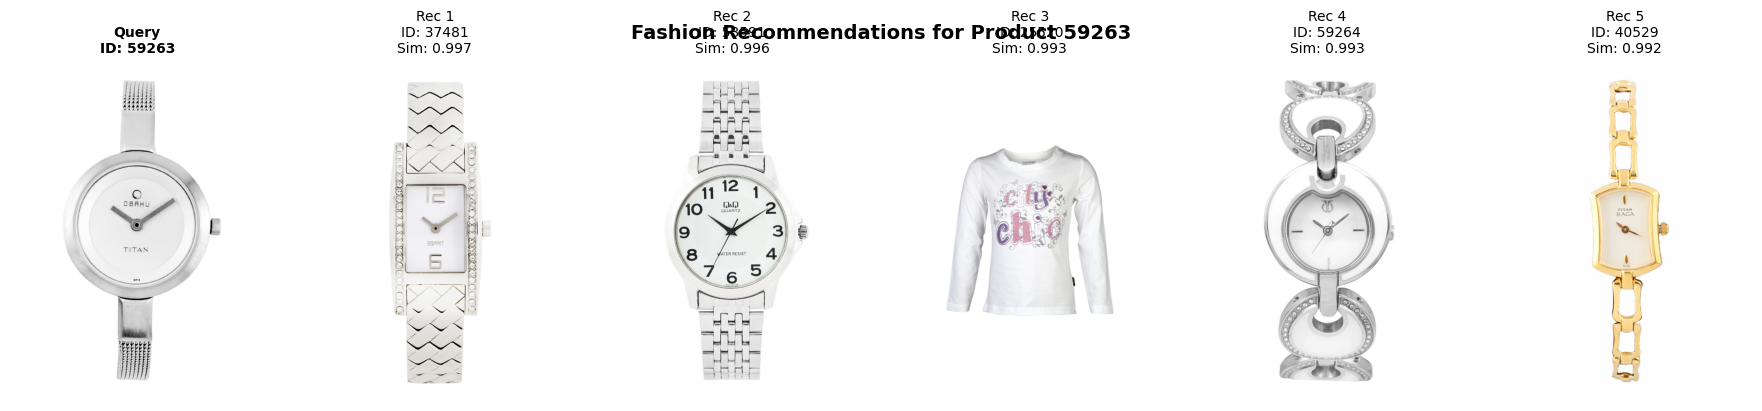

In [ ]:
if __name__ == "__main__":
    recommender = main()

In [ ]:
from tqdm import tqdm

def get_ground_truth(df):
    """
    Generates a dictionary of ground truth relevant items for each product.
    Items are considered relevant if they share the same 'articleType'.
    """
    ground_truth = {}

    article_groups = df.groupby('articleType')['id'].apply(set)

    for index, row in df.iterrows():
        product_id = row['id']
        article_type = row['articleType']

        relevant_items = article_groups.get(article_type, set()) - {product_id}
        ground_truth[product_id] = relevant_items

    return ground_truth

def calculate_average_precision(predicted, actual):
    """
    Calculates the Average Precision (AP) for a single recommendation list.
    """
    if not actual:
        return 0.0

    hits = 0
    sum_precision = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            hits += 1
            precision_at_k = hits / (i + 1)
            sum_precision += precision_at_k

    if hits == 0:
        return 0.0

    return sum_precision / min(len(actual), len(predicted))



print("1. Generating ground truth based on 'articleType'...")
# Note: I used the full styles_df for ground truth to have complete category info
full_styles_df = pd.read_csv('../input/fashion-product-images-dataset/fashion-dataset/styles.csv', on_bad_lines='skip')
ground_truth_data = get_ground_truth(full_styles_df)

test_product_ids = recommender.product_ids[:100]
average_precision_scores = []
k_for_recommendations = 10 # Number of recommendations to get for each item

print(f"2. Starting evaluation for {len(test_product_ids)} products...")

for product_id in tqdm(test_product_ids):

    actual_relevant_items = ground_truth_data.get(product_id, set())

    if not actual_relevant_items:
        continue

    # Get the top-k recommendations from the model
    recommendations_with_scores = recommender.get_recommendations(product_id, n_recommendations=k_for_recommendations)
    predicted_items = [rec_id for rec_id, score in recommendations_with_scores]

    # Calculate Average Precision for this product's recommendations
    ap = calculate_average_precision(predicted_items, actual_relevant_items)
    average_precision_scores.append(ap)

# Calculate Mean Average Precision (MAP)
if average_precision_scores:
    map_score = np.mean(average_precision_scores)
    print(f"\n{'='*50}")
    print(f"Mean Average Precision (MAP) @{k_for_recommendations} for {len(average_precision_scores)} test products: {map_score:.4f}")
    print(f"{'='*50}")
else:
    print("Could not calculate MAP. The test set might have been empty or had no relevant items.")

1. Generating ground truth based on 'articleType'...
2. Starting evaluation for 100 products...


100%|██████████| 100/100 [00:00<00:00, 590.75it/s]


Mean Average Precision (MAP) @10 for 100 test products: 0.2524
